### 0. Importy i konfiguracja środowiska (notebook)

In [2]:
# ### 0. Importy i konfiguracja środowiska (notebook)
# Funkcja:
# - wycisza FutureWarning z bibliotek Google w outputach,
# - ustawia PYTHONPATH na root repo (żeby działało: from src...),
# - ładuje importy używane w kolejnych komórkach.

import warnings
import sys
import subprocess

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module=r"google\.api_core\._python_version_support",
)

# root repo do PYTHONPATH (żeby działało: from src....)
_repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
if _repo_root not in sys.path:
    sys.path.insert(0, _repo_root)

import os
import io
import re
import math
import hashlib
import base64

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, HTML

import ipywidgets as widgets

from src.ocr.ocr_cache import run_ocr_cache
from src.ui.table_helpers import (
    ensure_edit_columns,
    filter_df_for_table,
    list_files,
    rows_to_lines,
    calc_height_px,
    normalize_edited_lines,
)
from src.exports.ocr_review_export import export_reviewed_lines, export_per_image
from src.viz.gallery import render_gallery

print("Repo root:", _repo_root)
print("sys.path[0]:", sys.path[0])

Repo root: /home/jupyter/ocr-search
sys.path[0]: /home/jupyter/ocr-search


### 1. Wybór folderu z bucketa (dropdown)

In [13]:
# ### 1. Wybór folderu z bucketa (dropdown)
# Funkcja: listuje foldery bezpośrednio w gs://ocr-2026/ i pozwala wybrać zestaw bez ręcznego składania ścieżek.
# Uwaga: OUT_OCR_CSV jest per-folder (oddzielny cache na zestaw).

BUCKET_ROOT = "gs://ocr-2026"          # tylko foldery na tym poziomie
OUTPUTS_DIR = "outputs/csv"
LIMIT_IMAGES = None                    # np. 5; None = wszystko

os.makedirs(OUTPUTS_DIR, exist_ok=True)

def list_bucket_folders(bucket_root: str) -> list[str]:
    r = subprocess.run(
        ["gcloud", "storage", "ls", f"{bucket_root.rstrip('/')}" + "/*"],
        capture_output=True,
        text=True,
    )
    if r.returncode != 0:
        raise RuntimeError(r.stderr.strip()[:2000])

    folders = []
    for line in r.stdout.splitlines():
        p = line.strip()
        if p.endswith("/"):
            # gs://ocr-2026/<folder>/
            name = p.rstrip("/").split("/")[-1]
            folders.append(name)

    return sorted(set(folders))

folders = list_bucket_folders(BUCKET_ROOT)
if not folders:
    raise RuntimeError(f"Brak folderów w {BUCKET_ROOT}/ (w konsoli GCS utwórz folder albo wgraj folder).")

folder_dd = widgets.Dropdown(
    options=folders,
    value=folders[0],
    description="Zestaw:",
    layout=widgets.Layout(width="520px"),
)

out = widgets.Output()

def _set_paths(_=None):
    with out:
        out.clear_output()

        folder = folder_dd.value
        gcs_prefix = f"{BUCKET_ROOT.rstrip('/')}/{folder}"       # tu są obrazy
        out_csv = os.path.join(OUTPUTS_DIR, f"ocr_lines__{folder}.csv")

        print("GCS_PHOTOS_PREFIX =", gcs_prefix)
        print("OUT_OCR_CSV       =", out_csv)

        # ustawiamy zmienne dla kolejnych komórek
        globals()["GCS_PHOTOS_PREFIX"] = gcs_prefix
        globals()["OUT_OCR_CSV"] = out_csv

folder_dd.observe(_set_paths, names="value")
display(folder_dd, out)
_set_paths()

Dropdown(description='Zestaw:', layout=Layout(width='520px'), options=('other photos', 'photos'), value='other…

Output()

# ### 2. OCR z cache (dla wybranego folderu)

In [3]:
### 2. OCR z cache (tylko brakujące pliki)
# Funkcja: uruchamia OCR tylko dla nowych obrazów (brakujących w OUT_OCR_CSV) i aktualizuje cache.

df_out = run_ocr_cache(
    gcs_photos_prefix=GCS_PHOTOS_PREFIX,
    out_csv=OUT_OCR_CSV,
    limit_images=LIMIT_IMAGES,
)

GCS files: 5
Cached OCR files: 21
Missing (to OCR now): 0
[SKIP] Brak nowych plików – OCR nie został uruchomiony (0 kosztów).
CSV rows: 121
CSV unique files: 21


### 3. Przygotowanie danych roboczych (df)

In [4]:
### 3. Przygotowanie danych roboczych (df)
# Funkcja: kopiuje wynik OCR z cache (df_out) do df – na df pracują kolejne komórki (watermark, tabela, eksport, galeria).

df = df_out.copy()
df.head()

,text,file_name,file_id,gcs_path,page,line_id,bbox_norm,script,source
0,ODZIEŻ,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,0,"202.0,467.0,309.0,522.0",latin,gcv_ocr_line
1,damska,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,1,"213.0,514.0,305.0,555.0",latin,gcv_ocr_line
2,meska,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,2,"394.0,550.0,448.0,581.0",latin,gcv_ocr_line
3,dziewczęca,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,3,"166.0,538.0,302.0,594.0",latin,gcv_ocr_line
4,chłopieca,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,4,"393.0,580.0,470.0,617.0",latin,gcv_ocr_line


### 4. Parametry zapisu (eksport + galeria)

In [5]:
### 4. Parametry zapisu (eksport + galeria)
# Funkcja: ustawia ścieżkę zapisu wyników po edycji oraz źródło obrazów dla galerii (GCS lub lokalnie).

OUTPUT_CSV = "outputs/csv/ocr_lines_reviewed.csv"
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

PHOTOS_DIR = ""

### 5. Przygotowanie df do edycji

In [6]:
# ### 5. Przygotowanie df do edycji
# Funkcja: kopiuje df_out → df, dodaje text_edited, inicjalizuje excluded, wypisuje krótki raport.

df = df_out.copy()

if "text" not in df.columns:
    raise KeyError("Brak kolumny 'text' w df_out.")

df["text_edited"] = df["text"].astype(str)

if "excluded" not in df.columns:
    df["excluded"] = False

print("Rows:", len(df))
print("Files:", df["file_name"].nunique() if "file_name" in df.columns else 0)
display(df.head())

Rows: 121
Files: 21


,text,file_name,file_id,gcs_path,page,line_id,bbox_norm,script,source,text_edited,excluded
0,ODZIEŻ,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,0,"202.0,467.0,309.0,522.0",latin,gcv_ocr_line,ODZIEŻ,False
1,damska,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,1,"213.0,514.0,305.0,555.0",latin,gcv_ocr_line,damska,False
2,meska,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,2,"394.0,550.0,448.0,581.0",latin,gcv_ocr_line,meska,False
3,dziewczęca,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,3,"166.0,538.0,302.0,594.0",latin,gcv_ocr_line,dziewczęca,False
4,chłopieca,0002.jpg,6b63bcb80b9466fd8ab92d2ebee632ec4f4f4865,gs://ocr-2026/photos/0002.jpg,1,4,"393.0,580.0,470.0,617.0",latin,gcv_ocr_line,chłopieca,False


### 6. Watermark: wklej teksty

In [7]:
# ### 6. Watermark (excluded=True)
# Funkcja: oznacza linie zawierające podane frazy jako watermark (excluded=True).

display(HTML("<div style='font-weight:700; margin:8px 0'>Watermark do ignorowania (po jednej linii)</div>"))

wm_patterns = widgets.Textarea(
    value=(
        "ośrodek brama grodzka\n"
        "teatr nn\n"
        "tnn.pl\n"
        "archiwum jacka mirosława\n"
        "Archiwum Jacka Miroslawa\n"
        "OSRODEK BRAMA CROOZKA\n"
        "CREOZKA\n"
    ),
    placeholder="Dodaj kolejne watermarki (po jednej linii)",
    layout=widgets.Layout(width="100%", height="140px"),
)

apply_btn = widgets.Button(description="Zastosuj (oznacz watermark)")
wm_out = widgets.Output()

def apply_watermark_patterns(_):
    with wm_out:
        wm_out.clear_output()

        if "excluded" not in df.columns:
            df["excluded"] = False

        pats = [p.strip().lower() for p in wm_patterns.value.splitlines() if p.strip()]
        if not pats:
            print("Brak wpisanych tekstów watermark.")
            return

        base_col = "text_edited" if "text_edited" in df.columns else "text"
        s_low = df[base_col].astype(str).str.lower()

        mask = pd.Series(False, index=df.index)
        for p in pats:
            mask = mask | s_low.str.contains(p, na=False, regex=False)

        df.loc[mask, "excluded"] = True
        print(f"Oznaczono jako watermark: {int(mask.sum())} linii.")

apply_btn.on_click(apply_watermark_patterns)

display(wm_patterns)
display(apply_btn)
display(wm_out)

Textarea(value='ośrodek brama grodzka\nteatr nn\ntnn.pl\narchiwum jacka mirosława\nArchiwum Jacka Miroslawa\nO…

Button(description='Zastosuj (oznacz watermark)', style=ButtonStyle())

Output()

### 7. Tabela edycyjna (1 wiersz = 1 zdjęcie)

In [8]:
# ### 7. Tabela edycyjna (1 wiersz = 1 zdjęcie)
# Funkcja: grupuje OCR per plik, pomija watermark (excluded==True), umożliwia edycję text_edited; flush_table_to_df() zapisuje edycje do df.

# zapewnij kolumny potrzebne do edycji
df = ensure_edit_columns(df)

if "file_name" not in df.columns:
    raise KeyError("Brak kolumny 'file_name' w df.")

file_filter = widgets.Dropdown(
    options=["(wszystkie)"] + sorted(df["file_name"].dropna().astype(str).unique().tolist()),
    value="(wszystkie)",
    description="Plik:",
    layout=widgets.Layout(width="350px"),
)

text_filter = widgets.Text(
    value="",
    placeholder="filtr po tekście (substring)",
    description="Szukaj:",
    layout=widgets.Layout(width="520px"),
)

show_all = widgets.Checkbox(value=False, description="Pokaż wszystko (może spowolnić)")
render_btn = widgets.Button(description="Renderuj tabelę")
table_out = widgets.Output()

# list[(idxs_visible, edit_box, fn)]
_edit_groups = []

def render_table(_=None):
    global _edit_groups
    _edit_groups = []

    with table_out:
        table_out.clear_output()

        dff = filter_df_for_table(df, file_filter.value, text_filter.value)
        files = list_files(dff)

        if (not show_all.value) and len(files) > 10:
            print(f"Pokazuję 10 / {len(files)} plików. Zaznacz 'Pokaż wszystko', jeśli konieczne.")
            files = files[:10]

        display(widgets.HBox([
            widgets.HTML("<b>file</b>", layout=widgets.Layout(width="220px")),
            widgets.HTML("<b>teksty (oryg.)</b>", layout=widgets.Layout(width="420px")),
            widgets.HTML("<b>teksty (edycja)</b>", layout=widgets.Layout(width="420px")),
            widgets.HTML("<b>status</b>", layout=widgets.Layout(width="260px")),
        ]))

        for fn in files:
            g_all = dff[dff["file_name"] == fn].copy()

            m_excl = g_all["excluded"].eq(True) if "excluded" in g_all.columns else pd.Series(False, index=g_all.index)
            g_vis = g_all[~m_excl].copy()

            excl_count = int(m_excl.sum())
            total_count = int(len(g_all))

            if len(g_vis) == 0:
                status_html = f"<div style='color:#a00; font-weight:700'>tylko watermark ({excl_count}/{total_count})</div>"
                display(widgets.HBox([
                    widgets.HTML(fn, layout=widgets.Layout(width="220px")),
                    widgets.HTML("-", layout=widgets.Layout(width="420px")),
                    widgets.HTML("-", layout=widgets.Layout(width="420px")),
                    widgets.HTML(status_html, layout=widgets.Layout(width="260px")),
                ]))
                _edit_groups.append(([], None, fn))
                continue

            orig_lines = rows_to_lines(g_vis["text"])
            edit_lines = rows_to_lines(g_vis["text_edited"])

            if (not show_all.value) and len(orig_lines) > 80:
                orig_lines = orig_lines[:80]
                edit_lines = edit_lines[:80]
                idxs_visible = g_vis.index.tolist()[:80]
            else:
                idxs_visible = g_vis.index.tolist()

            h_px = calc_height_px(max(len(orig_lines), len(edit_lines)))

            orig_box = widgets.Textarea(
                value="\n".join(orig_lines),
                layout=widgets.Layout(width="420px", height=h_px),
                disabled=True,
            )
            edit_box = widgets.Textarea(
                value="\n".join(edit_lines),
                layout=widgets.Layout(width="420px", height=h_px),
            )

            status_html = (
                f"<div style='color:#a00; font-weight:700'>watermark usunięty: {excl_count}/{total_count}</div>"
                if excl_count > 0 else
                "<div style='color:#060; font-weight:700'>OK</div>"
            )

            _edit_groups.append((idxs_visible, edit_box, fn))

            display(widgets.HBox([
                widgets.HTML(fn, layout=widgets.Layout(width="220px")),
                orig_box,
                edit_box,
                widgets.HTML(status_html, layout=widgets.Layout(width="260px")),
            ]))

def flush_table_to_df():
    """Zapisuje edycje dla linii widocznych w tabeli."""
    for idxs_visible, edit_box, fn in _edit_groups:
        if not idxs_visible or edit_box is None:
            continue
        edited = normalize_edited_lines(edit_box.value.splitlines(), len(idxs_visible))
        df.loc[idxs_visible, "text_edited"] = edited

render_btn.on_click(render_table)

display(widgets.VBox([
    widgets.HBox([file_filter, text_filter]),
    widgets.HBox([show_all, render_btn]),
    table_out,
]))

### 8. Zapis wyników po edycji (audit + per_image)

In [9]:
# ### 8. Zapis wyników po edycji (audit + per_image)
# Funkcja: zapisuje pełne linie do OUTPUT_CSV oraz generuje plik __per_image.csv; drukuje krótki raport.

save_btn = widgets.Button(description="Zapisz CSV (reviewed)")
save_out = widgets.Output()

def save_reviewed(_):
    """Zapisuje df do OUTPUT_CSV i tworzy __per_image.csv."""
    with save_out:
        save_out.clear_output()

        flush_table_to_df()

        if "text_edited" not in df.columns and "text" in df.columns:
            df["text_edited"] = df["text"].astype(str)
        if "excluded" not in df.columns:
            df["excluded"] = False

        export_reviewed_lines(df, OUTPUT_CSV)
        print(f"[DONE] Zapisano (linie): {OUTPUT_CSV}")

        per_image_csv = export_per_image(df, OUTPUT_CSV)
        print(f"[DONE] Zapisano (1 wiersz / zdjęcie): {per_image_csv}")

        n_files = df["file_name"].nunique() if "file_name" in df.columns else 0
        n_rows = len(df)
        n_excl = int(df["excluded"].eq(True).sum()) if "excluded" in df.columns else 0
        print(f"Pliki: {n_files} | Wiersze: {n_rows} | excluded(watermark): {n_excl}")

save_btn.on_click(save_reviewed)
display(save_btn)
display(save_out)

Button(description='Zapisz CSV (reviewed)', style=ButtonStyle())

Output()

### 9. Galeria: miniatury z bboxami (pobieranie obrazów z GCS może potrwać chwilę)

[DONE] Galeria: OK=21, błędy=0, razem=21



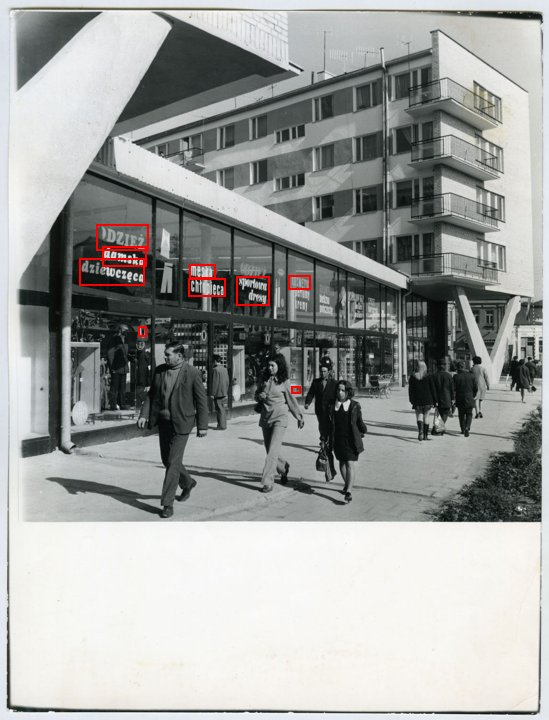
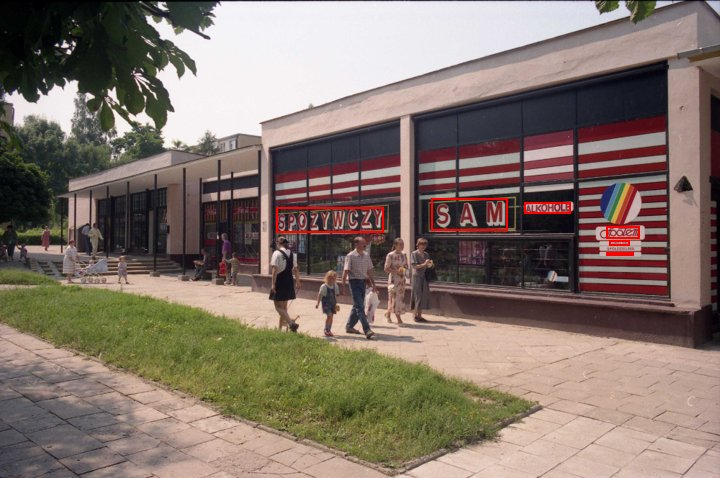
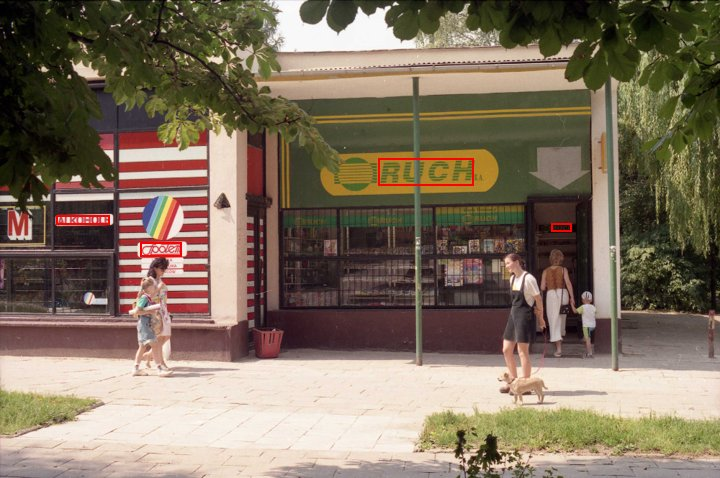
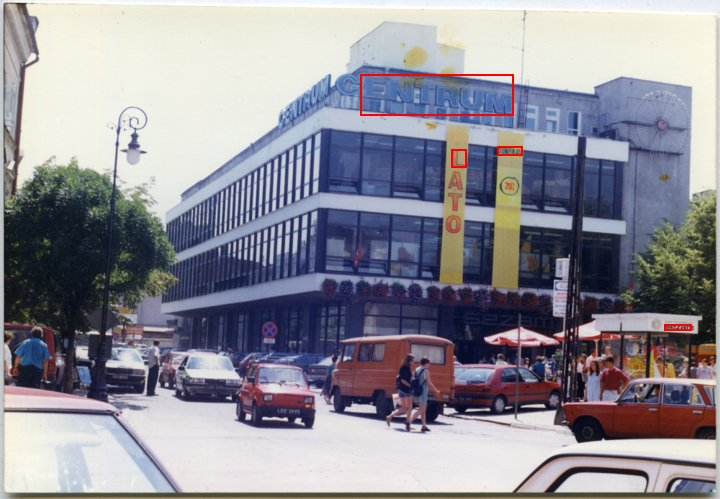
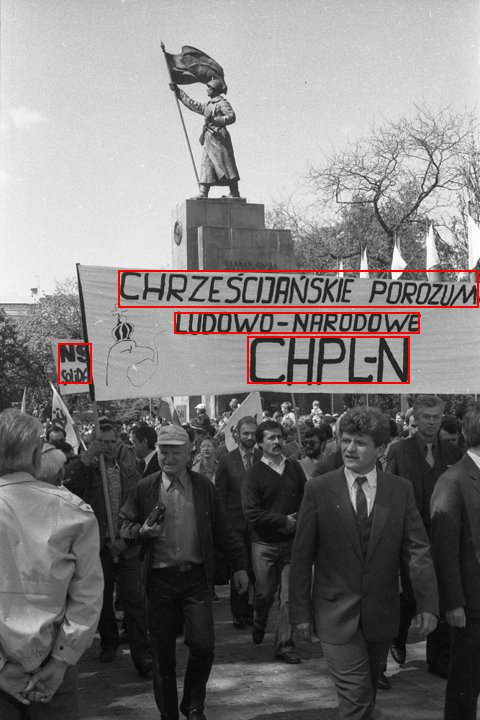
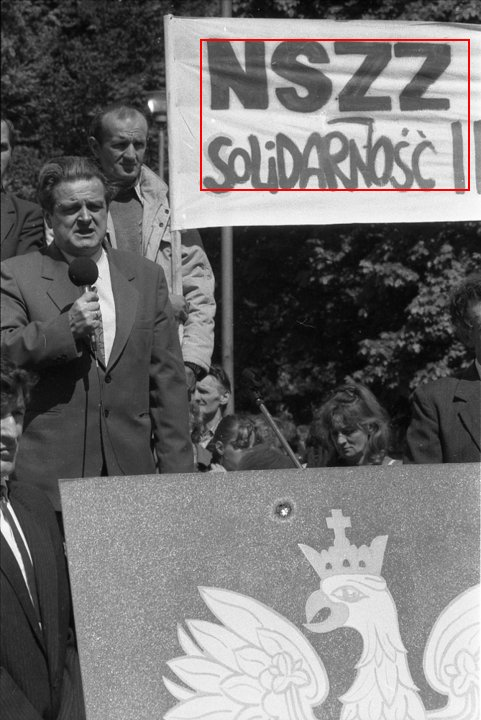
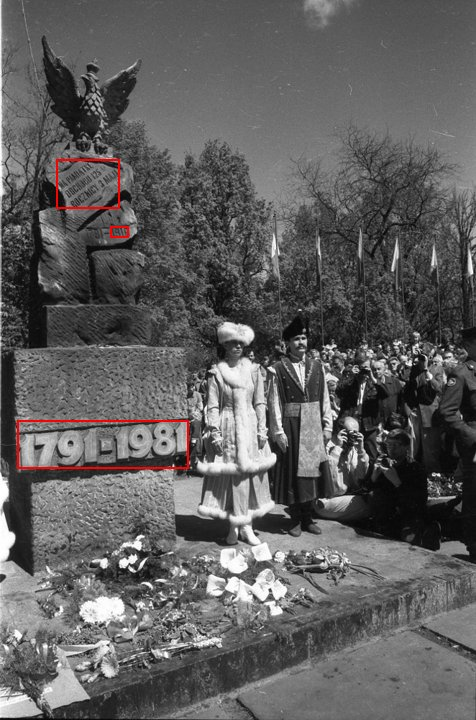
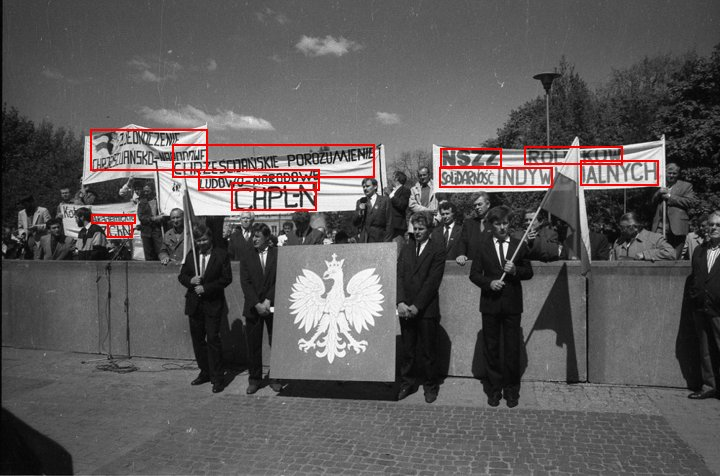
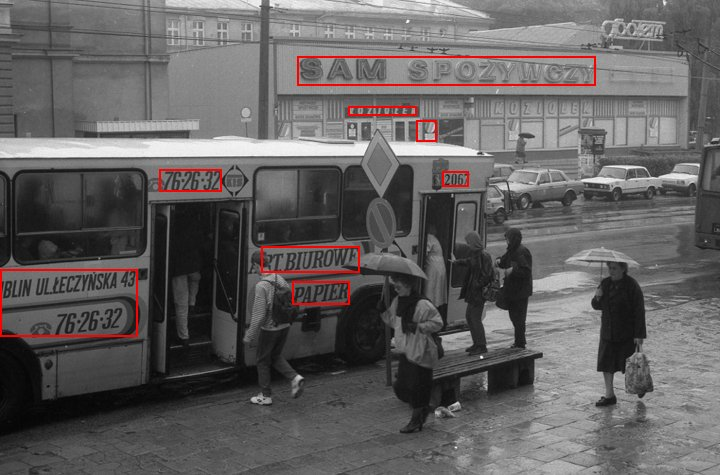
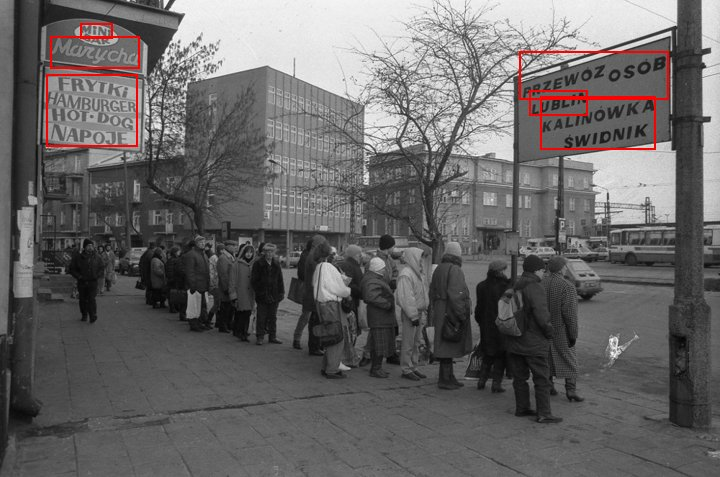
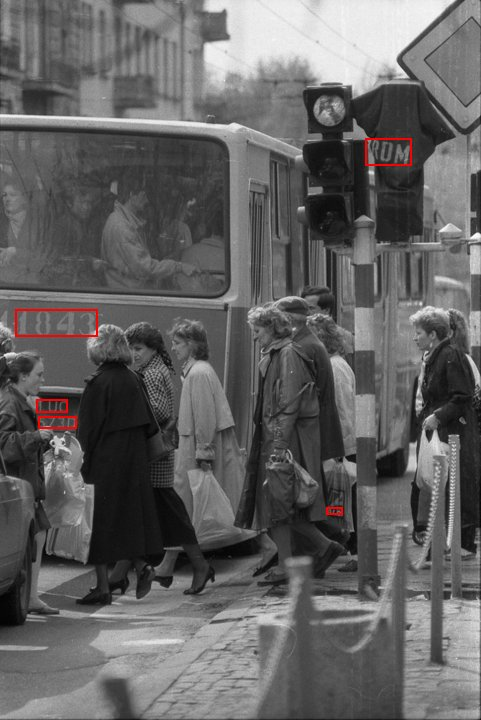
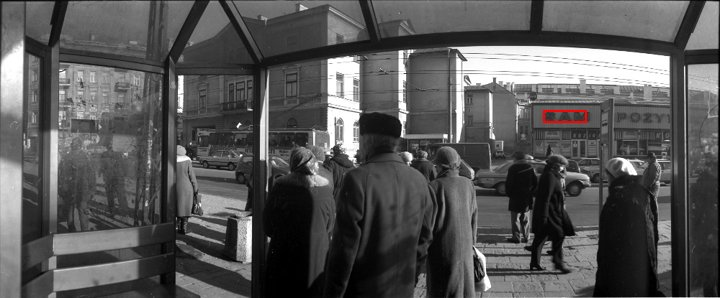
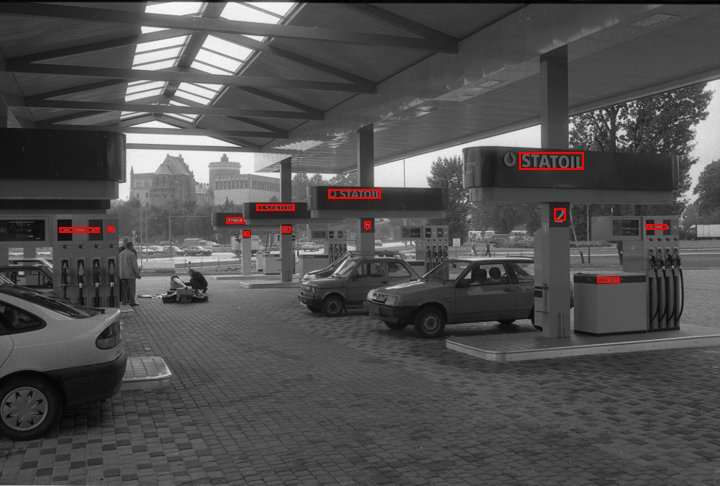
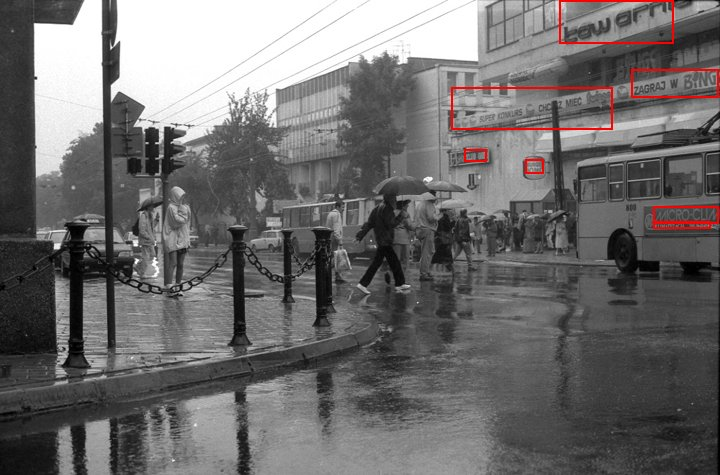
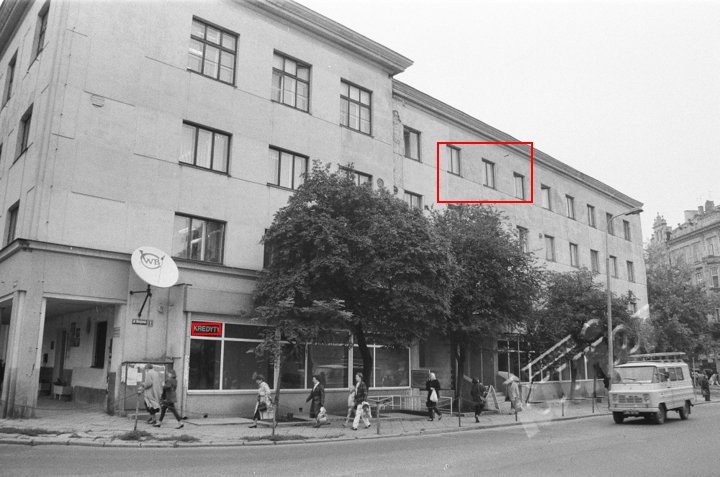
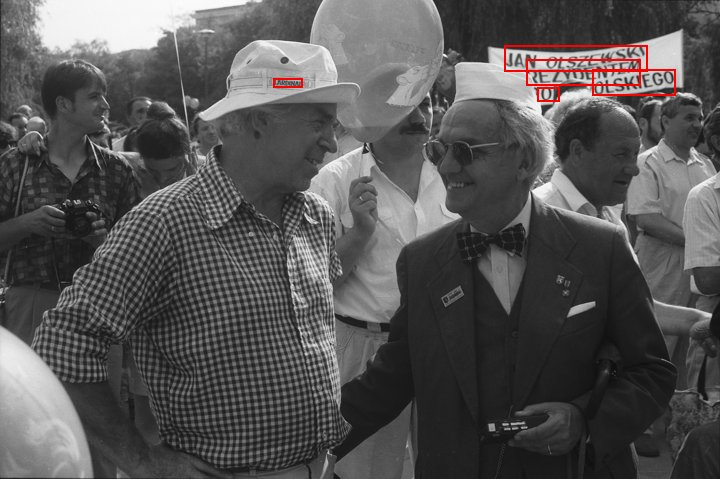
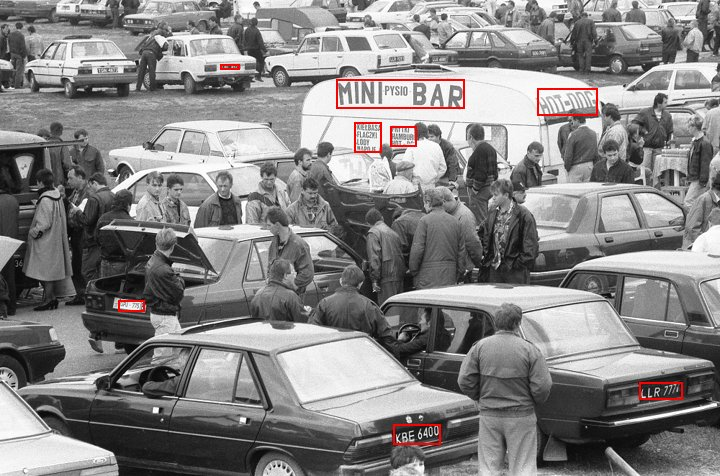
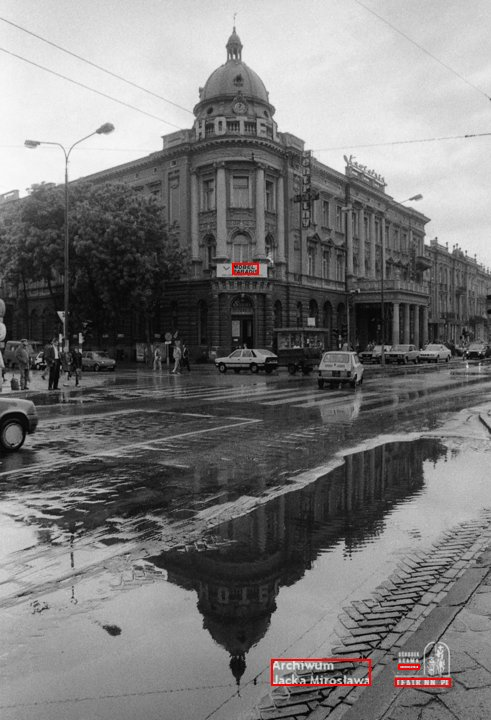
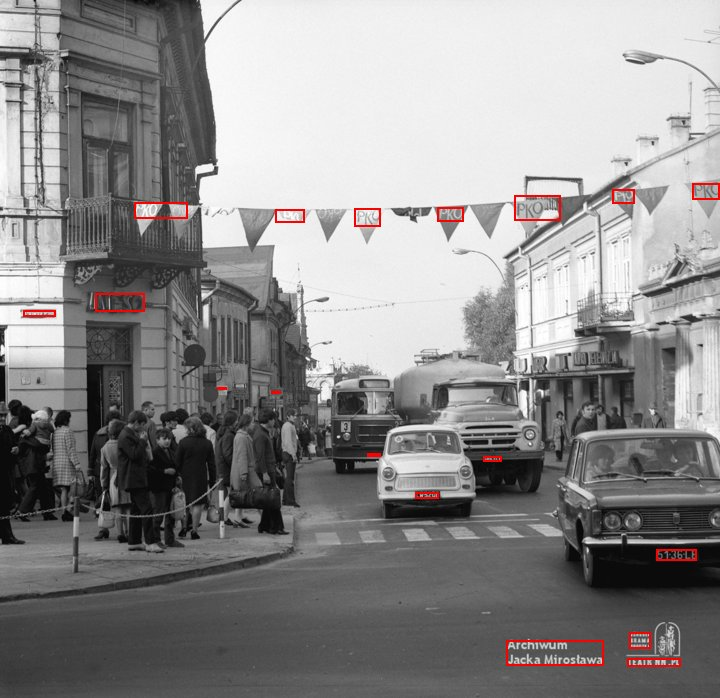
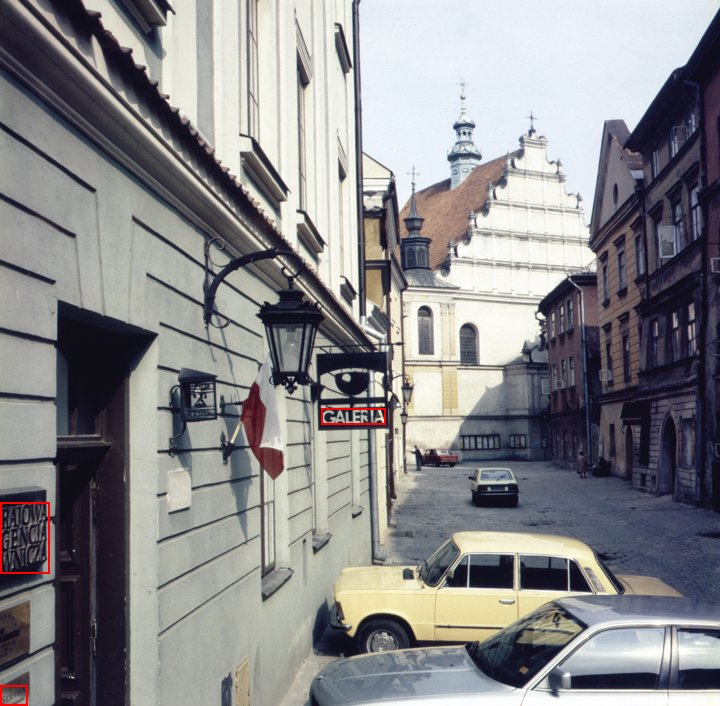
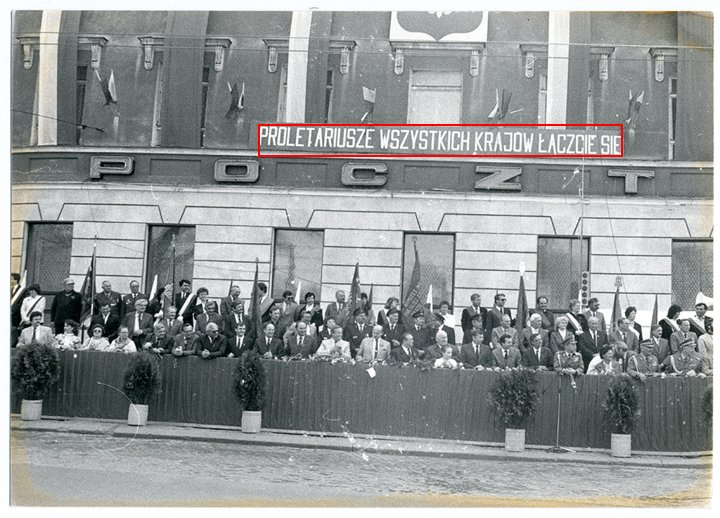

In [10]:
# ### 9. Galeria: miniatury z bboxami (podgląd jakości OCR)
# Funkcja: renderuje galerię miniatur z bboxami OCR;

MAX_SIDE = 720
LIMIT_GALLERY = 50  # 0/None = bez limitu

render_gallery(
    df=df,
    gcs_photos_prefix=GCS_PHOTOS_PREFIX,
    photos_dir=PHOTOS_DIR,
    max_side=MAX_SIDE,
    limit_gallery=LIMIT_GALLERY,
)